In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad

In [3]:
import utils
from model import Model

In [4]:
data = utils.read_data()

In [5]:
train_data = data['seen']['signal'][:, 0][::2]
train_bvals = data['seen']['bvals'][::2]
train_bvecs = data['seen']['bvecs'][::2]
train_delta = data['seen']['delta'][::2]
train_Delta = data['seen']['Delta'][::2]
train_te = data['seen']['TE'][::2]
train_g = data['seen']['g'][::2]

test_data = data['seen']['signal'][:, 0][1::2]
test_bvals = data['seen']['bvals'][1::2]
test_bvecs = data['seen']['bvecs'][1::2]
test_delta = data['seen']['delta'][1::2]
test_Delta = data['seen']['Delta'][1::2]
test_te = data['seen']['TE'][1::2]
test_g = data['seen']['g'][1::2]


In [6]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=train_Delta, small_delta=train_delta)
test_gtab = grad.gradient_table(test_bvals, test_bvecs, big_delta=test_Delta, small_delta=test_delta)

In [7]:
train_s0 = train_data[train_gtab.b0s_mask]

In [8]:
#model = sfm.SparseFascicleModel(train_gtab, isotropic=sfm.ExponentialIsotropicModel)
#model = dti.TensorModel(train_gtab)
model = Model(train_gtab, isotropic=sfm.ExponentialIsotropicModel)#, alpha=0.000000001, l1_ratio=0.01)

In [9]:
fit = model.fit(train_data, TE=train_te)

In [10]:
predict = fit.predict(test_gtab, test_te)

In [11]:
np.unique(train_Delta)

array([   0.,   17.,   19.,   20.,   21.,   23.,   37.,   38.,   39.,
         40.,   44.,   56.,   63.,   66.,   76.,   79.,   80.,   81.,
         82.,   87.,   95.,  100.,  102.,  109.,  113.,  114.,  119.,
        120.,  121.,  130.])

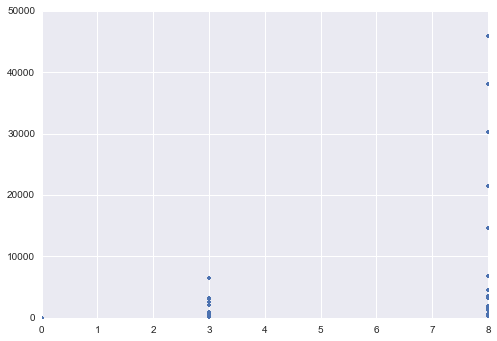

In [12]:
plt.plot(train_delta, train_gtab.bvals, '.')

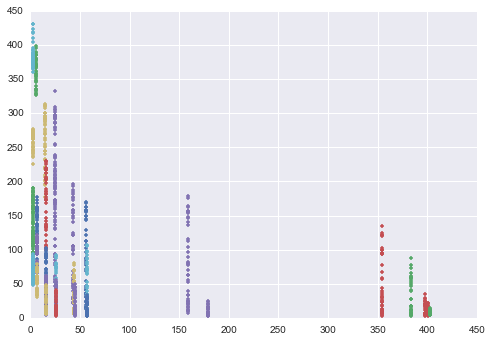

In [13]:
fig, ax = plt.subplots(1)
for this_Delta in np.unique(train_Delta):
    idx = train_Delta==this_Delta
    ax.plot(train_gtab.bvals[idx]/this_Delta, train_data[idx], '.', label=this_Delta)

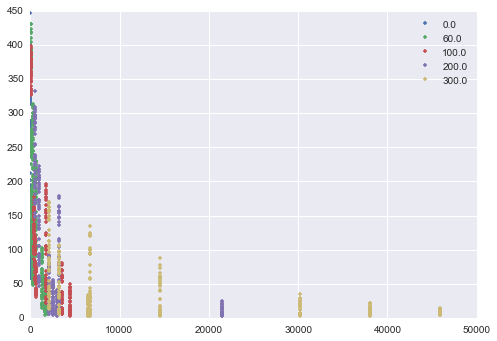

In [14]:
fig, ax = plt.subplots(1)
for this_g in np.unique(train_g):
    idx = train_g==this_g
    ax.plot(train_gtab.bvals[idx], train_data[idx], '.', label=this_g)
plt.legend()

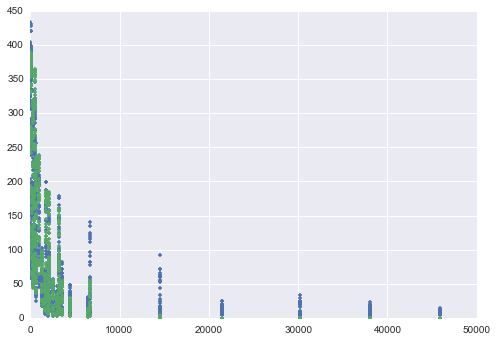

In [15]:
plt.plot(test_gtab.bvals, test_data, '.')
plt.plot(test_gtab.bvals, predict, '.')

In [16]:
def LSE(prediction, signal, sigma=8):
    return np.mean(((prediction - np.sqrt(signal**2 + sigma**2))**2)/(sigma**2))

In [17]:
LSE(predict, test_data)

4.4977375696192334

In [18]:
LSE(np.ones_like(train_data) * np.mean(train_data), train_data)

179.96553385160149

In [19]:
np.unique(test_Delta).shape

(30,)

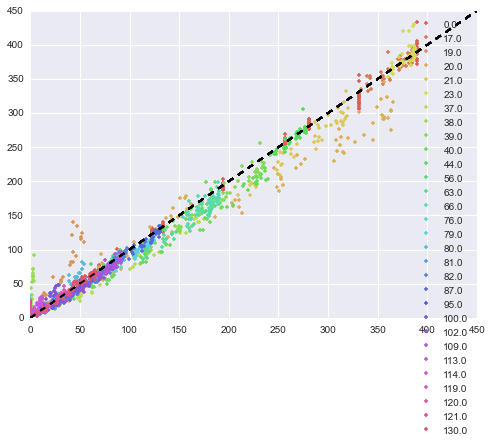

In [20]:
with sns.color_palette("hls", 30):
    fig, ax = plt.subplots(1)
    for this_Delta in np.unique(test_Delta):
        idx = test_Delta==this_Delta
        ax.plot(predict[idx], test_data[idx], '.', label=this_Delta)
        plt.plot([0, 450], [0, 450], 'k--')
    plt.legend()

In [21]:
import dipy.viz.projections as proj

In [22]:
import dipy.data as dpd

In [23]:
s = dpd.get_sphere()

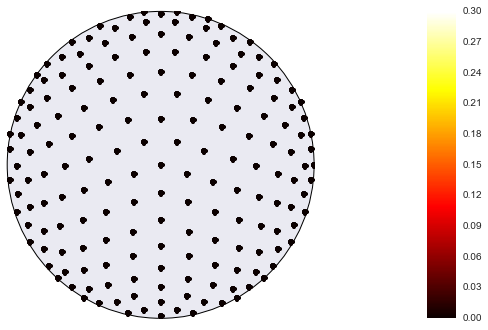

In [29]:
proj.sph_project(s.vertices.T, fit.beta, vmax=0.3)

In [25]:
fit.te_params

array([  2.92842438e-07,  -7.07956717e-05,  -1.29515371e-02,
         6.73556582e+00])

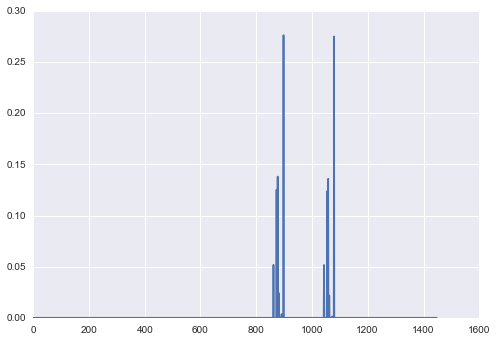

In [26]:
plt.plot(fit.beta)